In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,balanced_accuracy_score,f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,StackingClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
#from skopt import BayesSearchCV
#from skopt.space import Real, Categorical, Integer

# Funkcje pomocnicze

In [2]:
def income_metric(y,yp,credit,intrestRate = None):
    if (intrestRate == None):
        gain_max = sum(credit)
        gain = sum(np.multiply(credit,(yp==y)))
        return gain/gain_max
    else:
        gain_max = sum(credit*intrestRate)
        gain = sum(np.multiply((yp==y),intrestRate,credit))
        return gain/gain_max
def gain_part(y,yp,credit):
    y = np.matrix(y).transpose()
    gain = [0 for _ in range(len(y))]
    for i in range(len(y)):
        if (yp[i]==0):
            if (y[i]==0):
                gain[i] = 1
            else:
                gain[i] = -1
    gain =  sum(np.multiply(credit,gain))
    return gain
def income_metric2(y,yp,credit,intrestRate = None):
    gain_max = sum(np.multiply(credit,(y==0)))
    y = np.matrix(y).transpose()
    gain = [0 for _ in range(len(y))]
    for i in range(len(y)):
        if (yp[i]==0):
            if (y[i]==0):
                gain[i] = 1
            else:
                gain[i] = -1
    gain =  sum(np.multiply(credit,gain))
    return gain/gain_max
def fuse_model(pipl1,pipl2,X_tr,X_ts,y_tr,y_ts):
#     X_tr.AMT_INCOME_TOTAL <= 300000
    X_model1_tr = X_tr.loc[X_tr.AMT_INCOME_TOTAL <= 200000]
    y_model1_tr = y_tr.loc[X_tr.AMT_INCOME_TOTAL <= 200000]
    X_model1_ts = X_ts.loc[X_ts.AMT_INCOME_TOTAL <= 200000]
    y_model1_ts = y_ts.loc[X_ts.AMT_INCOME_TOTAL <= 200000]

    X_model2_tr = X_tr.loc[X_tr.AMT_INCOME_TOTAL > 200000]
    y_model2_tr = y_tr.loc[X_tr.AMT_INCOME_TOTAL > 200000]
    X_model2_ts = X_ts.loc[X_ts.AMT_INCOME_TOTAL > 200000]
    y_model2_ts = y_ts.loc[X_ts.AMT_INCOME_TOTAL > 200000]
    

    pipl1.fit(X_model1_tr,y_model1_tr)
    y_model1_pred = pipl1.predict(X_model1_ts)

    print("______ MODEL 1 ______")

    conf_matrix = confusion_matrix(y_model1_ts, y_model1_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    balanced_acc = balanced_accuracy_score(y_model1_ts, y_model1_pred)
    print("Balanced Accuracy:", balanced_acc)
    income_per2 = income_metric2(y_model1_ts, y_model1_pred,X_model1_ts.AMT_CREDIT)
    print("Income2 %: ", income_per2)
    print("Income2 base %: ",
            gain_part(y_model1_ts, [0 for _ in range(len(y_model1_ts))],X_model1_ts.AMT_CREDIT)/sum(np.multiply(X_model1_ts.AMT_CREDIT,(y_model1_ts==0))))
    print('Money: ', gain_part(y_model1_ts, y_model1_pred,X_model1_ts.AMT_CREDIT))
    print('Money max: ', sum(np.multiply(X_model1_ts.AMT_CREDIT,(y_model1_ts==0))))


    pipl2.fit(X_model2_tr,y_model2_tr)
    y_model2_pred = pipl2.predict(X_model2_ts)

    print("______ MODEL 2 ______")


    conf_matrix2 = confusion_matrix(y_model2_ts, y_model2_pred)
    print("Confusion Matrix:")
    print(conf_matrix2)
    balanced_acc2 = balanced_accuracy_score(y_model2_ts, y_model2_pred)
    print("Balanced Accuracy:", balanced_acc2)
    income_per22 = income_metric2(y_model2_ts, y_model2_pred,X_model2_ts.AMT_CREDIT)
    print("Income2 %: ", income_per22)
    print("Income2 base %: ",
            gain_part(y_model2_ts, [0 for _ in range(len(y_model2_ts))],X_model2_ts.AMT_CREDIT)/sum(np.multiply(X_model2_ts.AMT_CREDIT,(y_model2_ts==0))))
    print('Money: ', gain_part(y_model2_ts, y_model2_pred,X_model2_ts.AMT_CREDIT))
    print('Money max: ', sum(np.multiply(X_model2_ts.AMT_CREDIT,(y_model2_ts==0))))

    print("______ MODEL FUSED ______")

    gain_max = sum(np.multiply(X_model1_ts.AMT_CREDIT,(y_model1_ts==0))) + sum(np.multiply(X_model2_ts.AMT_CREDIT,(y_model2_ts==0)))
    gain = gain_part(y_model1_ts, y_model1_pred,X_model1_ts.AMT_CREDIT) + gain_part(y_model2_ts, y_model2_pred,X_model2_ts.AMT_CREDIT)

    conf_matrix_fuse = conf_matrix + conf_matrix2
    print("Confusion Matrix fused:")
    print(conf_matrix_fuse)
    # balanced_acc2 = balanced_accuracy_score(y_model2_ts, y_model2_pred)
    # print("Balanced Accuracy:", balanced_acc2)
    print("Income2 fusef %: ", gain/gain_max)

       

In [21]:
def pipe(model):
    return Pipeline([
    ('transformer', StandardScaler_22(['id','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'])),
    ('dropper',Dropper(['id'])),
    ('minmax',MinMaxTransformer(['HOUR_APPR_PROCESS_START'])),
    ("estimator", model)
    ])

# Przygotowanie danych

In [3]:
df = pd.read_csv("../Data/Modeling_dataset/credit_PRO.csv")

data = df['AMT_INCOME_TOTAL']
print('Wejściowy rozmiar: ', data.shape[0])
upper_lim = data.quantile(.99)
df = df[( df.AMT_INCOME_TOTAL< upper_lim)]
print('Wyjściowy rozmiar: ', df.shape[0])

X = df.drop(["TARGET"],axis = 1)
y = df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Wejściowy rozmiar:  14000
Wyjściowy rozmiar:  13860


In [4]:
goods_price_impute = X_train['AMT_GOODS_PRICE'].dropna().median()
days_employed_impute = df.loc[df["DAYS_EMPLOYED"]<0].DAYS_EMPLOYED.mean()
days_employed_impute

-2350.6807458803123

In [5]:
class StandardScaler_22(BaseEstimator, TransformerMixin):
    def __init__(self,classes):
        self.classes = classes
        self.std_scaler = [StandardScaler() for _ in range(len(classes))]

    def fit(self,df,y= None):
        for i,col in enumerate(self.classes):
            self.std_scaler[i].fit(np.log1p(df[[col]]))
        return self
    
    def transform(self,X,y= None):
    
        Xc = X.copy()

        Xc.loc[X['CNT_CHILDREN'] > 4, 'CNT_CHILDREN'] = 4

        Xc['AMT_GOODS_PRICE'] = Xc['AMT_GOODS_PRICE'].fillna(goods_price_impute)
        Xc['Rate'] = ((np.ceil(Xc.AMT_CREDIT/Xc.AMT_ANNUITY) * Xc.AMT_ANNUITY) - Xc.AMT_CREDIT)/Xc.AMT_GOODS_PRICE
        # Xc['Rate_Count'] = np.ceil(Xc.AMT_CREDIT/Xc.AMT_ANNUITY)

        Xc['BAD_DAYS_EMPLOYED'] = (Xc['DAYS_EMPLOYED'] > 0).astype(int)
        Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute    
       
        Xc['DAYS_EMPLOYED'] = -Xc.DAYS_EMPLOYED
        Xc['DAYS_BIRTH'] = -Xc.DAYS_BIRTH

        Xc[' AMT_CREDIT / AMT_ANNUITY'] = Xc.AMT_CREDIT / Xc.AMT_ANNUITY
        Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = Xc.AMT_ANNUITY / Xc.DAYS_BIRTH
        Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] =Xc.AMT_GOODS_PRICE / Xc.AMT_INCOME_TOTAL
        Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = Xc.AMT_GOODS_PRICE / Xc.AMT_CREDIT

        for i,col in enumerate(self.classes):
            Xc[col] = self.std_scaler[i].transform(np.log1p(Xc[[col]]))

        # Xc[' AMT_CREDIT / AMT_ANNUITY'] = Xc.AMT_CREDIT / Xc.AMT_ANNUITY
        # Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = Xc.AMT_ANNUITY / Xc.DAYS_BIRTH
        # Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] =Xc.AMT_GOODS_PRICE / Xc.AMT_INCOME_TOTAL
        # Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = Xc.AMT_GOODS_PRICE / Xc.AMT_CREDIT

        # # w RandomForestClassifier nie pomogło
        # s = StandardScaler()
        # Xc['DAYS_REGISTRATION'] = np.sqrt(-Xc['DAYS_REGISTRATION'])
        # s.fit(Xc[['DAYS_REGISTRATION']])
        # Xc['DAYS_REGISTRATION'] = s.transform(Xc[['DAYS_REGISTRATION']])


        # s1 = StandardScaler()
        # Xc['DAYS_BIRTH'] = -Xc['DAYS_BIRTH']
        # s1.fit(Xc[['DAYS_BIRTH']])
        # Xc['DAYS_BIRTH'] = s1.transform(Xc[['DAYS_BIRTH']])

        # Xc['BAD_DAYS_EMPLOYED'] = (Xc['DAYS_EMPLOYED'] > 0).astype(int)
        # Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute

        # Xc['DAYS_EMPLOYED'] = np.log1p(-Xc.DAYS_EMPLOYED)
        # Xc['DAYS_BIRTH'] = np.log1p(-Xc.DAYS_BIRTH)
        return Xc


In [6]:
class Dropper(BaseEstimator, TransformerMixin):
    def __init__(self,classes):
        self.classes = classes

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        Xc = X.copy()
        return Xc.drop(self.classes, axis=1)


class FeatureAdd(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
            return self
    
    def transform(self, X, y=None):
        Xc = X.copy()
        Xc['Rate'] = ((np.ceil(X.AMT_CREDIT/X.AMT_ANNUITY) * X.AMT_ANNUITY) - X.AMT_CREDIT)
        return Xc
    
class MinMaxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,classes):
         self.scaler = [MinMaxScaler() for _ in range(len(X))]
         self.classes = classes
         
    def fit(self, X, y=None):
            for i,col in enumerate(self.classes):
                self.scaler[i].fit(X[[col]])
            return self
    
    def transform(self, X, y=None):
        Xc = X.copy()
        for i,col in enumerate(self.classes):
             Xc[col] = self.scaler[i].transform(Xc[[col]])
        return Xc

# Cross Walidacja

In [8]:
def cv(n,pipel):
    # zwraca średnią balanced accuracy, średni income, variancje
    ans = []
    kf = KFold(n_splits=n,shuffle=True,random_state=17)
    kf.get_n_splits(df)
    # pipline - musi być ustalony
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        df_cv_train = df.iloc[train_index]
        goods_price_impute = df_cv_train['AMT_GOODS_PRICE'].dropna().median()
        days_employed_impute = df_cv_train.loc[df_cv_train["DAYS_EMPLOYED"]<0].DAYS_EMPLOYED.mean()
        X_train = df_cv_train.drop(["TARGET"],axis = 1)
        y_train = df_cv_train["TARGET"]

        df_cv_test = df.iloc[test_index]
        X_test = df_cv_test.drop(["TARGET"],axis = 1)
        y_test = df_cv_test["TARGET"]

        
        pipel.fit(X_train,y_train)
        y_pred = pipel.predict(X_test)
        # conf_matrix = confusion_matrix(y_test, y_pred)
        
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        f1_scr = f1_score(y_test,y_pred)
        income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
        ans.append([balanced_acc,income_per2,f1_scr])
    return [
        np.matrix(ans)[:,0].mean(),
        np.matrix(ans)[:,1].mean(),
        np.matrix(ans)[:,1].var(),
        np.matrix(ans)[:,2].mean()]


In [10]:
def cv1(n,pipel):
    # zwraca średnią balanced accuracy, średni income, variancje
    ans = []
    kf = KFold(n_splits=n,shuffle=True,random_state=17)
    kf.get_n_splits(df)
    # pipline - musi być ustalony
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        df_cv_train = df.iloc[train_index]
        goods_price_impute = df_cv_train['AMT_GOODS_PRICE'].dropna().median()
        days_employed_impute = df_cv_train.loc[df_cv_train["DAYS_EMPLOYED"]<0].DAYS_EMPLOYED.mean()
        X_train = df_cv_train.drop(["TARGET"],axis = 1)
        y_train = df_cv_train["TARGET"]

        df_cv_test = df.iloc[test_index]
        X_test = df_cv_test.drop(["TARGET"],axis = 1)
        y_test = df_cv_test["TARGET"]

        
        pipel.fit(X_train,y_train)
        y_pred = pipel.predict(X_test)
        # conf_matrix = confusion_matrix(y_test, y_pred)
        
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        f1_scr = f1_score(y_test,y_pred)
        income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
        ans.append([balanced_acc,f1_scr,income_per2])

    return ans

In [31]:
def crossval_models_performance(models,names,metric):
    results = []
    for model in models:
        a =cv1(10,model)
        if metric == "balanced_accuracy":
            results.append([sublist[0] for sublist in a])
        elif metric == "f1_score":
            results.append([sublist[1] for sublist in a])
        else:
            results.append([sublist[2] for sublist in a])
    pyplot.boxplot(results, labels=names, showmeans=True)
    pyplot.title(metric)
    pyplot.show()

# Dostrajanie hiperparametrów
zdecydowaliśmy się na sprawdzenie optymalnych kombinacji hiperparametrów dla następujących modeli:
- GradinetBoostingClassiffier
- XGBClassifier
- RandomForestClassifier
- DecisionTreeClassifier
- KNN

Zapisywaliśmy kombinacje parametrów dla których wartości metryk: f1-score, balance accuracy i income były najlesze. Dodatkowo kombinacje dla ktorej srednia tych metryk była najlepsza

## Gradient Boosting Classifier

## XGBClassifier

In [ ]:
learning_rate= [0.05,0.1, 0.2, 0.4, 0.5]
n_estimators= [20, 40, 50, 70]
max_depth= [3, 5, 7, 9]
booster = ['gbtree', 'gblinear', 'dart']

combinations = all_combinations([learning_rate, n_estimators, max_depth,booster])

max_income = 0
max_f1 = 0
max_balanced_acc = 0
max_avg = 0
max_combination_avg = []
max_combination_inc = []
max_combination_f1 = []
max_combination_bal = []
max_conf = None

# Wyświetlenie wyników
for combination in combinations:
    
    p = Pipeline([
    ('transformer', StandardScaler_22(['id','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'])),
    ('dropper',Dropper(['id'])),
    ('minmax',MinMaxTransformer(['HOUR_APPR_PROCESS_START'])),
    ("estimator", XGBClassifier(learning_rate=combination[0],
                                      n_estimators=combination[1],
                                      max_depth=combination[2],
                                      booster=combination[3]))
    ])
    
    l = cv(3,p)
    print(l)
    f1 = l[3]
    income = l[1]
    balacc = l[0]
    if (max_income<income):
        max_combination_inc = combination
        max_income = income
        # max_conf = confusion_matrix(y_test,y_pred)
    if (max_f1 < f1):
        max_combination_f1 = combination
        max_f1 = f1
    if (max_balanced_acc<balacc):
        max_combination_bal = combination
        max_balanced_acc = balacc
    if(max_avg < (f1+balacc+income)/3):
        max_combination_avg = combination
        max_avg = (f1+balacc+income)/3  

In [ ]:
# Best params for XGBClassifeir
Max income: 0.7961055336003041(0.1, 40, 5, 'gbtree')
Max f1: 0.17949518838033854(0.5, 70, 7, 'gbtree')
Max balanced acc: 0.5342556664912362(0.5, 70, 5, 'gbtree')
Max avg params: 0.49473761647878894(0.5, 70, 5, 'gbtree')

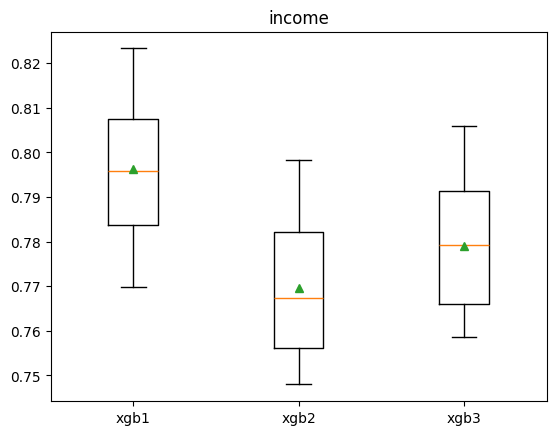

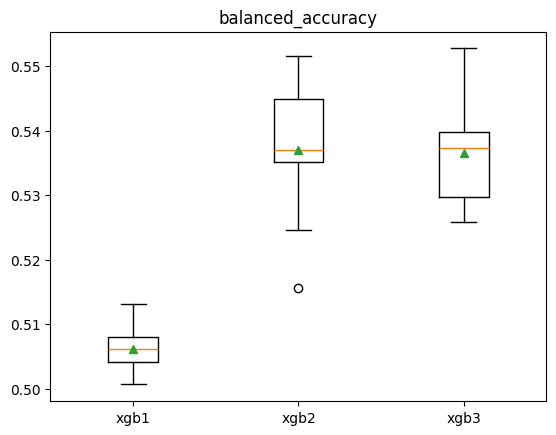

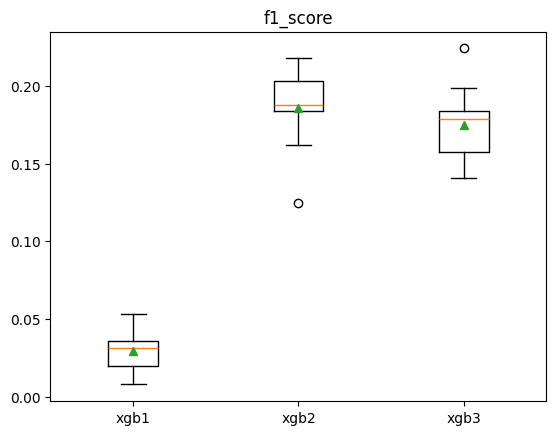

In [32]:
xgb1 = pipe(XGBClassifier(learning_rate=0.1,n_estimators=40, max_depth=5,booster='gbtree'))
xgb2 = pipe(XGBClassifier(learning_rate=0.5,n_estimators=70, max_depth=7,booster='gbtree'))
xgb3 = pipe(XGBClassifier(learning_rate=0.5,n_estimators=70, max_depth=5,booster='gbtree'))
crossval_models_performance([xgb1,xgb2,xgb3],['xgb1','xgb2','xgb3'],'income')
crossval_models_performance([xgb1,xgb2,xgb3],['xgb1','xgb2','xgb3'],'balanced_accuracy')
crossval_models_performance([xgb1,xgb2,xgb3],['xgb1','xgb2','xgb3'],'f1_score')


## Decision Tree Classifier

In [ ]:
criterion= ['gini', 'entropy']
splitter= ['best', 'random']
max_depth= [None, 5, 10, 20]
class_weight= [None, 'balanced'] 

combinations = all_combinations([criterion,splitter,max_depth,class_weight])

max_income = 0
max_f1 = 0
max_balanced_acc = 0
max_avg = 0
max_combination_avg = []
max_combination_inc = []
max_combination_f1 = []
max_combination_bal = []
max_conf = None

# Wyświetlenie wyników
for combination in combinations:
    
    p = Pipeline([
    ('transformer', StandardScaler_22(['id','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'])),
    ('dropper',Dropper(['id'])),
    ('minmax',MinMaxTransformer(['HOUR_APPR_PROCESS_START'])),
    ("estimator", DecisionTreeClassifier(criterion=combination[0],splitter=combination[1],max_depth=combination[2],class_weight=combination[3]))
    ])
    
    l = cv(3,p)
    print(l)
    f1 = l[3]
    income = l[1]
    balacc = l[0]
    if (max_income<income):
        max_combination_inc = combination
        max_income = income
    if (max_f1 < f1):
        max_combination_f1 = combination
        max_f1 = f1
    if (max_balanced_acc<balacc):
        max_combination_bal = combination
        max_balanced_acc = balacc
    if(max_avg < (f1+balacc+income)/3):
        max_combination_avg = combination
        max_avg = (f1+balacc+income)/3  

In [ ]:
# Best Params for decision tree
Max income: 0.7958939734400726('entropy', 'best', 5, None)
Max f1: 0.33636465694638734('gini', 'best', 5, 'balanced')
Max balanced acc: 0.5889511897489553('gini', 'best', 5, 'balanced')
Max avg params: 0.5025365209119901('gini', 'best', 5, 'balanced')

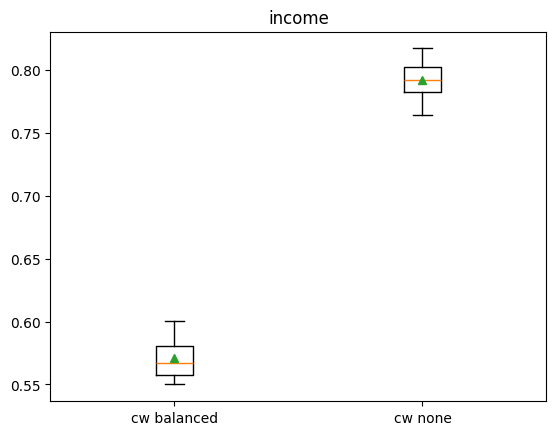

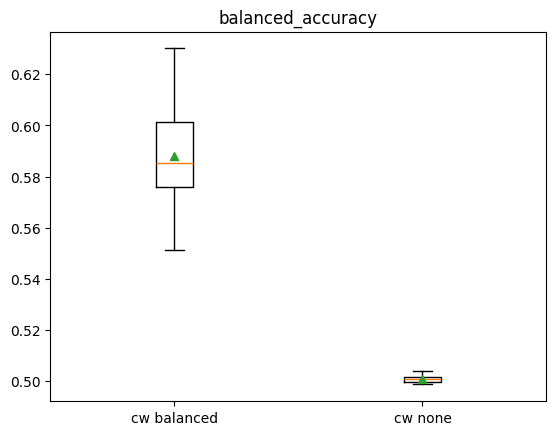

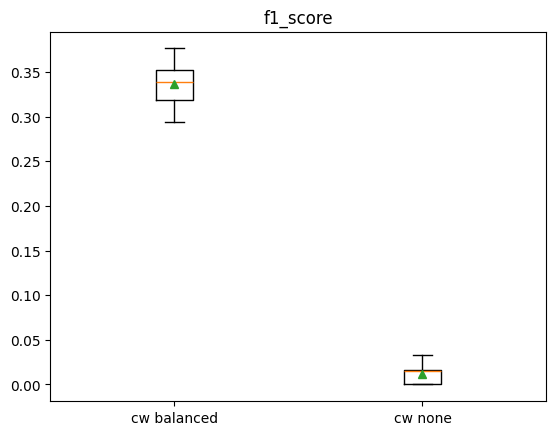

In [33]:
tree1 = pipe(DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=5,class_weight='balanced'))
tree2 = pipe(DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=5,class_weight=None))
crossval_models_performance([tree1,tree2],['cw balanced','cw none'],'income')
crossval_models_performance([tree1,tree2],['cw balanced','cw none'],'balanced_accuracy')
crossval_models_performance([tree1,tree2],['cw balanced','cw none'],'f1_score')


## Random forest

## KNN

# Stacking i voting

In [ ]:
p1 = Pipeline([
    ('transformer', StandardScaler_22(['id','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'])),
    ('minmax',MinMaxTransformer(['HOUR_APPR_PROCESS_START'])),
    ('dropper',Dropper(['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'DAYS_EMPLOYED','id'])),
    ("estimator", RandomForestClassifier(random_state=17))
]) # mało odżucal
p2 = Pipeline([
    ('transformer', StandardScaler_2(['AMT_INCOME_TOTAL','AMT_GOODS_PRICE'])),
    ('dropper',Dropper([ 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'id'])),
    ("estimator", DecisionTreeClassifier(random_state=17))
]) # dużo odrzucł
p3 = Pipeline([
    ('transformer', StandardScaler_22(['AMT_INCOME_TOTAL','AMT_GOODS_PRICE'])),
    ('minmax',MinMaxTransformer(['HOUR_APPR_PROCESS_START'])),
    ('dropper',Dropper(['id'])),
    ("estimator", SVC(kernel="sigmoid", random_state=17, max_iter=3001, probability=True))
]) # troche odrzucał
p4 = Pipeline([
        ('transformer', StandardScaler_22(['AMT_INCOME_TOTAL','AMT_GOODS_PRICE'])),
        ('dropper',Dropper(['id'])),
        ("estimator", KNeighborsClassifier(n_neighbors=16))
    ]) # nie wiem
p5 = Pipeline([
            ('transformer', StandardScaler_22(['id','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'])),
            ('minmax',MinMaxTransformer(['HOUR_APPR_PROCESS_START'])),
            ('dropper',Dropper(['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'id'])),
            ("estimator", GradientBoostingClassifier(learning_rate=0.3,n_estimators=30,random_state=17))
        ]) # nie wiem

estimators = [("p1",p1), ("p2",p2),("p3",p3),("p4",p4)]
pf = Pipeline([['clf3',
                 VotingClassifier(estimators=estimators,
                                  voting='soft',
                                  weights=[0.3,0.3,0.1,0.2])]])

pf.fit(X_train,y_train)
y_pred = pf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

In [ ]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

# Porównanie modeli

# Explainable AI

In [36]:
import shap

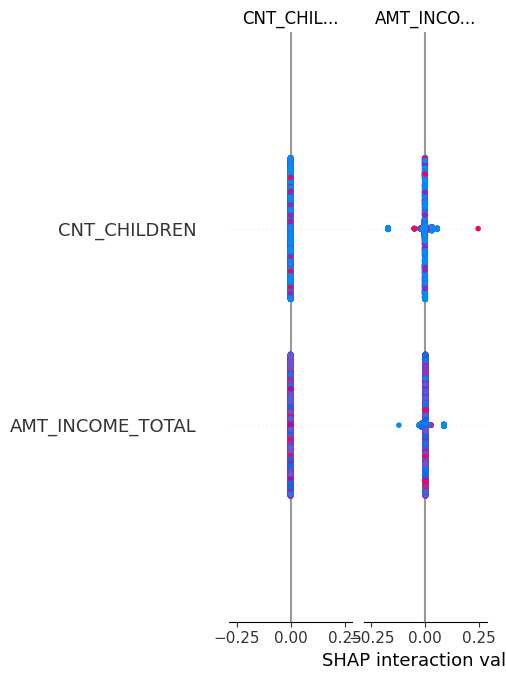

In [54]:
# model = best_model
tree1 = pipe(DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=5,class_weight='balanced'))
model = tree1
model.fit(X_train,y_train)

X_train_transformed = model[:-1].transform(X_train)

explainer = shap.Explainer(model.named_steps['estimator'], X_train_transformed)
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed)